In [1]:
try:
    import yahoo_fin.stock_info as si
except:
    !pip install yahoo_fin
    import yahoo_fin.stock_info as si

import tensorflow as tf
import datetime as dt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
import pandas as pd
import requests

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 KB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 12.6 MB/s eta 0:00:00
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24589 sha256=6ed6df756c114498ffe8aca7f67f61e9bf62c8030b51218ba56a7dae806d954c
  Stored in directory: /root/.cache/pip/wheels/d6/9c/58/ee3ba36897e890f3ad81e9b730791a153fce20caa4a8a474df
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=34e990b6a8f9d668893ec4a5c98366d3b1925524d1cf042ef52f4ee02e374190
  Stored in directory: /root/.cache/pip/wheels/65/7a/a7/78c287f64e401255dff4c13fdbc672f

In [2]:
# name of the stock and time interval to forcast
stock_name  = "AAPL"
Start_Date = "2022-11-01"
End_Date = dt.datetime.now()

# Sets the global random seed.
tf.random.set_seed(0)

# download the data fromm yahoo fin
yf_data = si.get_data(stock_name, start_date= Start_Date, end_date= End_Date, index_as_date = True, interval = "1d")

# pre process
data_frame = pd.DataFrame(data=yf_data)
data_frame['close'].fillna(method='ffill')

# get close data
close_data_frame = data_frame.filter(['close'])
close_data = close_data_frame.values

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close_data = scaler.fit_transform(close_data)

# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(close_data) * .95 ))

# Create the training data set 
# Create the scaled training data set
train_data = scaled_close_data[0:int(training_data_len), :]

# generate the input and output sequences
n_lookback = 60  # length of input sequences (lookback period)
n_forecast = 30  # length of output sequences (forecast period)

# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(n_lookback, len(train_data)):
    x_train.append(train_data[i-n_lookback:i, 0])
    y_train.append(train_data[i, 0])
    if i<= n_lookback+1:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.76064691, 0.59385672, 0.41133724, 0.39649824, 0.41252416,
       0.42973745, 0.2923282 , 0.64846412, 0.7324529 , 0.6903102 ,
       0.74254331, 0.70544582, 0.76272458, 0.7796408 , 0.68229702,
       0.74669821, 0.77311206, 0.685265  , 0.56981762, 0.47929965,
       0.68289071, 0.69120051, 0.67636151, 0.6413417 , 0.53093952,
       0.47247384, 0.52322295, 0.50868103, 0.57783081, 0.60691511,
       0.53984301, 0.34070347, 0.2816441 , 0.21813321, 0.21605599,
       0.30954149, 0.21397831, 0.2029976 , 0.14868681, 0.03027168,
       0.13622211, 0.14571883, 0.00148399, 0.03976863, 0.        ,
       0.13651873, 0.15224803, 0.16946132, 0.25137287, 0.24899858,
       0.2890636 , 0.32408387, 0.30241906, 0.30419967, 0.38136218,
       0.47751904, 0.51966174, 0.49977754, 0.56210151, 0.62056674])]
[0.5336104324017974]

[array([0.76064691, 0.59385672, 0.41133724, 0.39649824, 0.41252416,
       0.42973745, 0.2923282 , 0.64846412, 0.7324529 , 0.6903102 ,
       0.74254331, 0.70544582, 0.762

In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

32/32 [==============================] - 11s 14ms/step - loss: 0.0838


In [4]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_close_data[training_data_len - n_lookback: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = close_data[training_data_len:, :]
for i in range(n_lookback, len(test_data)):
    x_test.append(test_data[i-n_lookback:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1/1 [==============================] - 1s 1s/step


6.376776432742942

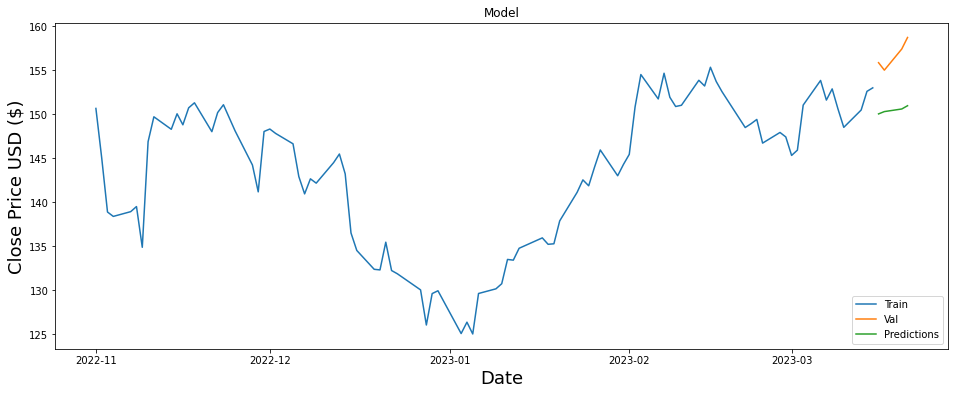

In [5]:
# Plot the data
train = close_data_frame[:training_data_len]
valid = close_data_frame[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [6]:
# Show the valid and predicted prices
valid

,close,Predictions
2023-03-16,155.850006,150.028900
2023-03-17,155.000000,150.291641
2023-03-20,157.399994,150.586960
2023-03-21,158.714996,150.957306


In [7]:
import json
chart_data = []
train = train['2022-01-01' :'2023-12-31']
for d,v in train.iterrows():
            dct ={}
            dct["date"] = d.strftime("%Y-%m-%d")
            dct["close"] = v.close
            chart_data.append(dct)

print(chart_data)

[{'date': '2022-11-01', 'close': 150.64999389648438}, {'date': '2022-11-02', 'close': 145.02999877929688}, {'date': '2022-11-03', 'close': 138.8800048828125}, {'date': '2022-11-04', 'close': 138.3800048828125}, {'date': '2022-11-07', 'close': 138.9199981689453}, {'date': '2022-11-08', 'close': 139.5}, {'date': '2022-11-09', 'close': 134.8699951171875}, {'date': '2022-11-10', 'close': 146.8699951171875}, {'date': '2022-11-11', 'close': 149.6999969482422}, {'date': '2022-11-14', 'close': 148.27999877929688}, {'date': '2022-11-15', 'close': 150.0399932861328}, {'date': '2022-11-16', 'close': 148.7899932861328}, {'date': '2022-11-17', 'close': 150.72000122070312}, {'date': '2022-11-18', 'close': 151.2899932861328}, {'date': '2022-11-21', 'close': 148.00999450683594}, {'date': '2022-11-22', 'close': 150.17999267578125}, {'date': '2022-11-23', 'close': 151.07000732421875}, {'date': '2022-11-25', 'close': 148.11000061035156}, {'date': '2022-11-28', 'close': 144.22000122070312}, {'date': '2022

In [10]:
chart_data = []
for d,v in valid.Predictions.items():
            dct ={}
            dct["date"] = d.strftime("%Y-%m-%d")
            dct["close"] = v
            chart_data.append(dct)
         

In [22]:
# generate the forecasts
X_ = scaled_close_data[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

1/1 [==============================] - 0s 22ms/step


In [18]:
Y_.size

1

In [19]:
X_.size

60

In [13]:
df_past = data_frame[['close']].reset_index()
df_past.rename(columns={'index': 'Date', 'close': 'Actual'}, inplace=True)

df_past['Date'] = pd.to_datetime(df_past['Date'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]


df_future = pd.DataFrame(columns=['Date', 'Actual', 'Forecast'])
df_future['Date'] = pd.date_range(start=df_past['Date'].iloc[-1] + pd.Timedelta(days=1), periods=n_forecast)
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan

results = df_past.append(df_future).set_index('Date')

# plot the results
results.plot(title=stock_name)

ValueError: ignored